In [2]:
import matplotlib.pyplot as plt
from math import floor
from matplotlib import gridspec

"""
Problem-specific plotting
"""
class Plot:
    def __init__(self):
        plt.rcParams["figure.autolayout"] = True
        self.fig = plt.figure()
        self.cnt = 0
        self.new_ax = None

    def add(self, y, label=None):
        if label != None:
            self.new_ax.plot(y, label=label)
            self.new_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                                 ncol = 2, fancybox=True, shadow=True,
                                 handleheight=2.4, labelspacing=0.05)
        else:
            self.new_ax.plot(y)

    def inc(self):
        """Plots the data to a new subplot at the bottom."""
        self.cnt += 1
        gs = gridspec.GridSpec(self.cnt, 1)

        # Reposition existing subplots
        for i, ax in enumerate(self.fig.axes):
            ax.set_position(gs[i].get_position(self.fig))
            ax.set_subplotspec(gs[i])

        # Add new subplot
        self.new_ax = self.fig.add_subplot(gs[self.cnt-1])
        
        
    def add_new(self, y, label="No Label"):
        self.inc()
        self.add(y, label)

    def add_new_assignment_plot(self, assignments, labels=[], fuzzy=False, length=0):
        self.inc()
        for idx, ts in enumerate(assignments):
            if not fuzzy:
                y = []
                if length == 0:
                    length = max( [ max(ts) for ts in assignments if ts != [] ] )
                for t in range(length):
                    if t in ts:
                        y.append(1)
                    else:
                        y.append(0)
            else:
                y = ts
            if max(y) > 0:
                if labels == None:
                    self.add(smoothed(y,1))
                elif labels == []:
                    self.add(smoothed(y, 1), idx)
                else:
                    self.add(smoothed(y, 1), str(labels[idx]))

    def add_new_conceptors_fit_plot(self, X, Cs, Ns=None, label="", labels=""):
        """
        Plots, for each time step t, how well each conceptor in Cs matches the state x(t)
        """
        self.inc()
        if Ns:
            collection = evidences_for_Cs(X,Cs,Ns)
        else:
            collection, _ = test(X, Cs, "PROP")
        if labels:
            for vals, label in zip(collection, labels):
                # walking average of d
                self.add(smoothed(vals, 3), label=label)
        else:                
            for i, vals in enumerate(collection):
                # walking average of d
                self.add(smoothed(vals, 3), label=label+str(i))


    def finalize(self, title=""):
        self.fig.suptitle(title, fontsize=16)
        plt.show()

In [3]:
delta=False
delta_delta=False

fv, lv, sr = fc.collectFeatures(
    ft="Train",n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=speakers,dr=dr,sentence=sentence,
    path_option=path_option
)

-from output
---- success


In [4]:
# init reservoir
import random
random.seed(0)
np.random.seed(0)
#t_max = 1000
t_test = 50
t_washout = 0 # number of washout steps
aperture = 5

esn_params = {
    "in_dim": n_mels*(1+delta+delta_delta),
    "out_dim": n_mels*(1+delta+delta_delta),
    "N": 50,
    "W_in_scale": 1.5,
    "b_scale": .2,
    "spectral_radius": 1.5
}

esn = ESN(esn_params)
X, _ = esn.run_X(fv.T, t_washout, fv.shape[0])
print(X.shape)

(50, 24076)


In [5]:
group = {}
phonemes = []
for i in range(X.shape[1]):
    if lv[i] not in phonemes:
        phonemes.append(lv[i])
for phoneme in phonemes:
    group[phoneme] = X[:,lv==phoneme]

min_samples = max([len(samples) for samples in group.values()])

phonemes = list(group.keys())
print(str(len(phonemes))+" phonemes")
print(group.keys())

39 phonemes
dict_keys(['h#', 't', 'ih', 'm', 'ey', 'sh', 'iy', 'l', 's', 'uw', 'v', 'z', 'w', 'ay', 'ah', 'k', 'ow', 'hh', 'ae', 'b', 'n', 'er', 'dh', 'aa', 'eh', 'p', 'r', 'dx', 'd', 'f', 'ng', 'g', 'th', 'jh', 'y', 'aw', 'uh', 'ch', 'oy'])


In [6]:
params = str(aperture)+"_"+str(esn_params["N"])+"_"+str(min_samples)

file_name = "CsX"+"_"+params+"_"+path_option

if save and os.path.exists('./cache/working/'+"Cs"+file_name+'.pkl') and os.path.exists('./cache/working/'+"Ns"+file_name+'.pkl'):
    print("- loading conceptors from file")
    Cs_fp = open('./cache/working/'+"Cs"+file_name+'.pkl','rb')
    Cs = pkl.load(Cs_fp)
    Cs_fp.close()
    Ns_fp = open('./cache/working/'+"Ns"+file_name+'.pkl','rb')
    Ns = pkl.load(Ns_fp)
    Ns_fp.close()
    print("--- Done")
else:
    print("- computing conceptors")
    Cs = []
    for phoneme, states in group.items():
        Cs.append(compute_c(states, aperture))
    print(Cs[0].shape)
    print("- computing negative conceptors")
    Ns = Ns_from_Cs(Cs)
    print("- optimizing +")
    Cs = optimize_apertures(Cs)
    print("- optimizing -")
    Ns = optimize_apertures(Ns)

    if save:
        Cs_fp = open("./cache/working/"+"Cs"+file_name+".pkl",'wb')
        pkl.dump(Cs,Cs_fp)
        Cs_fp.close()
        Ns_fp = open("./cache/working/"+"Ns"+file_name+".pkl",'wb')
        pkl.dump(Ns,Ns_fp)
        Ns_fp.close()

    print("--- Done")

- loading conceptors from file
--- Done


In [11]:
#------ Custom test
from scipy.ndimage import gaussian_filter

nb_conceptors = len(Cs)
nb_points = X.shape[1]
correct = 0
n=0
fv, lv, sr = fc.collectFeatures(
    ft="Train",n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=speakers,dr=dr,sentence=sentence,
    path_option=path_option+"_test"
)

Xtest, _ = esn.run_X(fv.T, t_washout, fv.shape[0])

sigma = 3
Es = np.array(evidences_for_Cs(Xtest, Cs, Ns))
for c in range(nb_conceptors):
    Es[c,:] = gaussian_filter(Es[c,:], order=0, sigma=sigma)
for t in range(nb_points):
    prediction = list(group.keys())[np.argmax(Es[:,t])]
    correct += lv[t] == prediction
    n += 1

print("Accuracy: ",correct/n)
print("n_mels: ",n_mels)
print("d: ",delta)
print("dd: ",delta_delta)
print("speakers: ",speakers)
print("dr: ",dr)
print("min_samples: ",min_samples)
print("Test: ","Test")
print("subsamples: ",subsamples)
print("Neurons: ",esn_params["N"])
print("Aperture: ",aperture)

-from output
---- success
Accuracy:  0.6796394749958465
n_mels:  10
d:  False
dd:  False
speakers:  ['FCJF0']
dr:  []
min_samples:  50
Test:  Test
subsamples:  10
Neurons:  50
Aperture:  5


In [7]:
from enum import Enum

class Method(Enum):
    RANDOM = 0
    RANGES = 1
    EQUAL_SPLIT = 2

def assign_to_clusters(nb_points, nb_clusters, method=Method.EQUAL_SPLIT, limits=[]):
    """
    Assigns points to conceptors according to one of several assignment methods
    """
    assignments = [ [] for _ in range(nb_clusters) ]
    if method == Method.RANDOM or method == Method.EQUAL_SPLIT:
        points = [ x for x in range(nb_points) ]
        if method == Method.RANDOM:
            np.random.shuffle(points)
        for i in range(nb_clusters):
            assignments[i] = points[i*int(nb_points/nb_clusters):(i+1)*int(nb_points/nb_clusters)]
    elif method == Method.RANGES:
        mark = 0
        for i in range(nb_points):
            if i in limits:
                mark += 1
            assignments[mark].append(i)
    return assignments

def assign_fuzzy_to_clusters(nb_points, nb_clusters, transition_time):
    """
    Distributes points over clusters smoothly changing float membership
    """
    assignments = [ [] for _ in range(nb_clusters) ]
    mean_length = int(nb_points/nb_clusters)
    current = -1
    for t in range(nb_points):
        if not t % mean_length:
            current += 1
        for i in range(nb_clusters):
            if i == current:
                if t % mean_length > mean_length - transition_time and not i + 1 == nb_clusters:
                    assignments[i].append(1 - (t % mean_length - (mean_length - transition_time)) * 1 / transition_time)
                else:
                    assignments[i].append(1)
            elif i == current + 1 and t % mean_length > mean_length - transition_time:
                assignments[i].append((t % mean_length - (mean_length - transition_time)) * 1 / transition_time)
            else:
                assignments[i].append(0)
    return assignments

In [8]:
from scipy.ndimage import gaussian_filter

def kmeans(X, nb_conceptors, method, limits, aperture, max_epochs=100, sigma=1, plot=None):
    """
    Kmeans algorithm, adapted to conceptors
    """
    print("K-means")
    # Initial assignments and initial conceptors
    nb_points = X.shape[1]
    new_assignments = assign_to_clusters(nb_points, nb_conceptors, method, limits)
    # Training loop
    for epoch in range(max_epochs):
        print("epoch:",epoch)
        # recompute centroids based on subset of assigned state
        Cs = [ compute_c(X[:,assignments], aperture) for assignments in new_assignments ]
        Ns = Ns_from_Cs(Cs)
        #print("- optimizing +")
        Cs = optimize_apertures(Cs)
        #print("- optimizing -")
        Ns = optimize_apertures(Ns)
        if plot != None and epoch == 0:
            plot.add_new_assignment_plot(new_assignments)
        elif plot:
            plot.add_new_assignment_plot(new_assignments,None)
        
        # recompute assignments by find the closest conceptor for each of the state points
        old_assignments = new_assignments.copy()
        new_assignments = [ [] for _ in range(nb_conceptors) ]
        
        Es = np.zeros((nb_conceptors, nb_points))
        for t in range(nb_points):
            Es[:,t] = np.array( evidences_for_Cs_z(X[:,t], Cs, Ns) )
        
        for c in range(nb_conceptors):
            Es[c,:] = gaussian_filter(Es[c,:], order=0, sigma=sigma)
        
        for t in range(nb_points):
            conceptor_index = np.argmax(Es[:,t])
            new_assignments[ conceptor_index ].append(t)

        # stop if converged
        for new_assignment, old_assignment in zip(new_assignments, old_assignments):
            if set(new_assignment) == set(old_assignment):
                print("Converged")
                return Cs, Ns, new_assignments

    return Cs, Ns, new_assignments

K-means
epoch: 0
epoch: 1
epoch: 2
Converged
Accuracy: 0.26878504672897197
Baseline: 0.19104812567533871


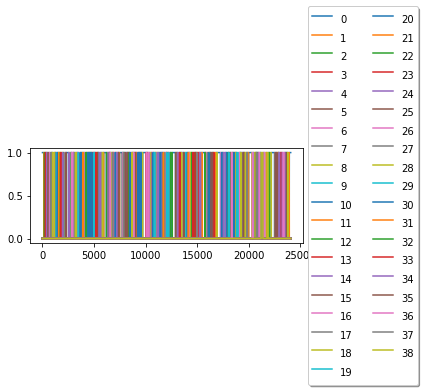

In [9]:
def experiment(X,nb_conceptors,sigma,plot):
    Cs_kmeans, Ns_kmeans, assignments_kmeans = kmeans(X, nb_conceptors=nb_conceptors, method=Method.RANDOM, limits=[],
                                           aperture=aperture, max_epochs=20, sigma=sigma, plot=plot)
    return Cs_kmeans, Ns_kmeans, assignments_kmeans

def test(assignments, phonemes, Cs, Ns):
    overlaps = np.zeros((len(phonemes), len(phonemes))) # (Cs x phonemes)

    for C_idx, assignment in enumerate(assignments):
        for idx in assignment:
            overlaps[C_idx, phonemes.index(lv[idx])] += 1

    dic = {}
    cnt = 0
    for _ in range(len(phonemes)):
        C_idx, phoneme_idx = np.unravel_index(overlaps.argmax(), overlaps.shape)
        dic[phonemes[phoneme_idx]] = C_idx
        cnt += overlaps[C_idx,phoneme_idx]
        overlaps[C_idx,:] = np.zeros((1,len(phonemes)))
        overlaps[:,phoneme_idx] = np.zeros((len(phonemes),))

    return(cnt/len(fv))

    Cs_final = []
    Ns_final = []
    for phoneme in [p for p in phonemes_kmeans if p in list(dic.keys()) ]:
        Cs_final.append(Cs[dic[phoneme]])
        Ns_final.append(Ns[dic[phoneme]])
    return Cs_final, Ns_final

def F_score(assignments, correct_assignments):
    overlaps = np.zeros((len(assignments), len(correct_assignments))) # (Cs x phonemes)

    for i1, assignment in enumerate(assignments):
        for a in assignment:
            for i2, correct_assignment in enumerate(correct_assignments):
                if a in correct_assignment:
                    overlaps[i1, i2] += 1

    dic = []
    cnt = 0
    for _ in range(len(correct_assignments)):
        i1, i2 = np.unravel_index(overlaps.argmax(), overlaps.shape)
        dic.append(i1)
        cnt += overlaps[i1,i2]
        overlaps[i1,:] = np.zeros((1,len(correct_assignments)))
        overlaps[:,i2] = np.zeros((len(assignments),))

    return cnt/max([ max(ass) for ass in assignments if ass != [] ])

plot = Plot()
plt.rcParams['figure.dpi'] = 120
plt.rcParams["figure.figsize"] = (5,11)

sigma = 10
Cs_kmeans, Ns_kmeans, assignments_kmeans = experiment(X, len(Cs), sigma, plot=None)

### Testing
correct_assignments = [ [] for _ in range(len(Cs)) ]
for t, label in enumerate(lv):
    correct_assignments[phonemes.index(label)].append(t)
plot.add_new_assignment_plot(correct_assignments)
p = test_assignments(assignments_kmeans, correct_assignments)
print("Accuracy:",p)
p_baseline = test_assignments(assign_to_clusters(X.shape[1], len(Cs), Method.EQUAL_SPLIT), correct_assignments)
print("Baseline:",p_baseline)

plot.finalize()

In [ ]:
sims_Cs = np.zeros((len(phonemes),len(phonemes))) # Cs x Cs_kmeans

matches = 0
for x in range(len(phonemes)):
    for y in range(len(phonemes)):
        sim = similarity_c(Cs[x], Cs_kmeans[y])
        sims_Cs[x,y] = sim

dic = {}
for _ in range(len(phonemes)):
    C, C_kmeans = np.unravel_index(sims_Cs.argmax(), sims_Cs.shape)
    dic[phonemes[C]] = C_kmeans
    overlaps[C_idx,:] = np.zeros((1,len(phoenemes)))
    overlaps[:,phoneme_idx] = np.zeros((len(phoenemes),1))

print(matches / len(phonemes))
print("Random would be 1 <3")